#### Project wavs into UMAP and cluster using HDBSCAN
- for each individual, for each WAV, grab syllables as spectrograms of equal length
- project spectrograms into UMAP
- cluster UMAP projections

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [5]:
from avgn.signalprocessing.create_spectrogram_dataset import create_syllable_df

In [6]:
from avgn.visualization.projections import scatter_projections
from avgn.visualization.quickplots import draw_projection_plots
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [193]:
hparams = HParams(
    num_mel_bins = 32,
    butter_lowcut = 20000,
    butter_highcut = 124000,
    mel_lower_edge_hertz = 20000,
    mel_upper_edge_hertz = 124000,
    win_length_ms = .5,
    hop_length_ms = .1,
    n_fft = 1024,
    ref_level_db = 25,
    min_level_db = -70,
    reduce_noise=True,
    noise_reduce_kwargs = {"n_std_thresh": 1.5}
    )

In [194]:
DATASET_ID = 'tachibana_mouse'
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [195]:
syllable_dfs = {}
for indv in tqdm(dataset._unique_indvs[:3], desc="indvs"):
    print(indv)
    # create dataframe
    syllable_dfs[indv] = create_syllable_df(dataset, [indv], log_scaling_factor=8, n_jobs=1, pad_syllables = False)[:nex]
    break

Aco59_2


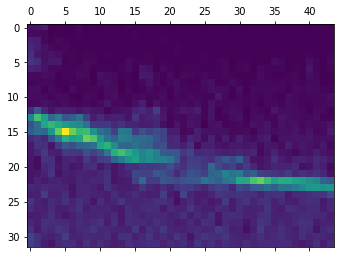

In [196]:
plt.matshow(np.array(syllable_dfs[indv].syllables_spec.values[10]))

In [197]:
def flatten_spectrograms(specs):
    return np.reshape(specs, (np.shape(specs)[0], np.prod(np.shape(specs)[1:])))

In [198]:
dataset._unique_indvs

array(['Aco59_2', 'Aco65_1', 'BALB128', 'Can15-1', 'Can16-1', 'Can3_1',
       'Can9-1', 'ClnBALB124'], dtype='<U10')

#### cluster and plot

In [199]:
nex = -1 # for quick viz, how many data points to fit

In [200]:
import collections 
def list_match(_list, list_of_lists):
    # Using Counter 
    return [collections.Counter(elem) == collections.Counter(_list) for elem in list_of_lists]

Aco59_2


[(333,), (85,)]


(25.0, 10) (320, 800) 25.0 32 800


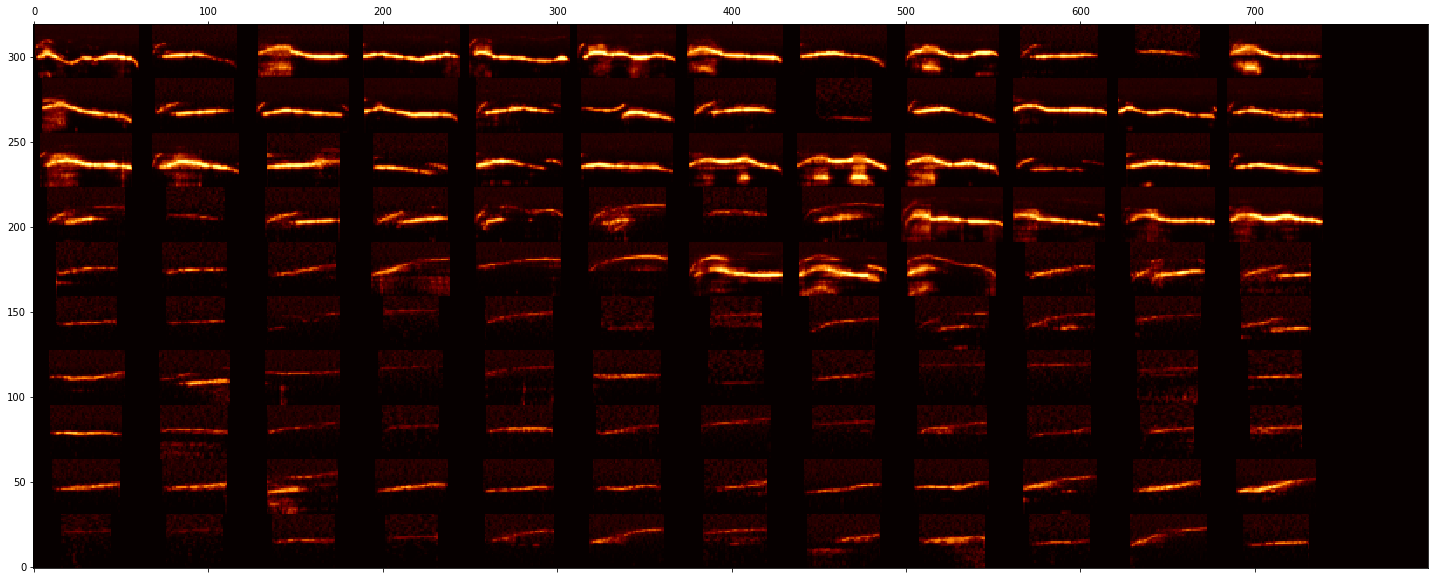

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


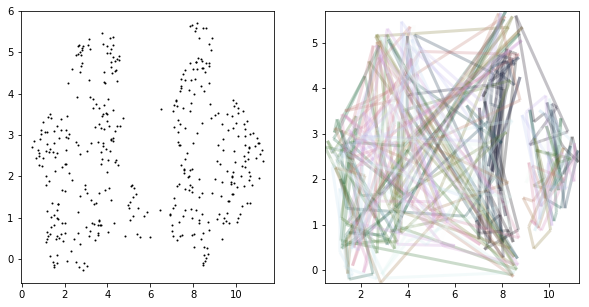

Aco65_1


[(383,)]


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


(25.0, 10) (320, 800) 25.0 32 800


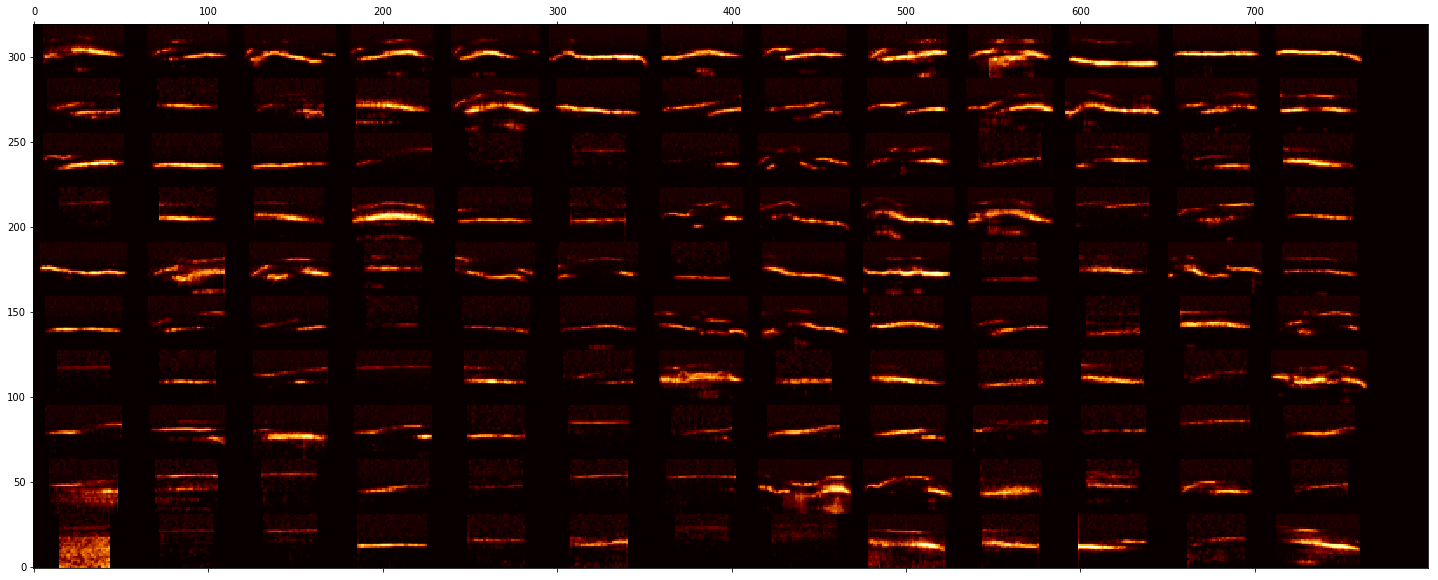

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


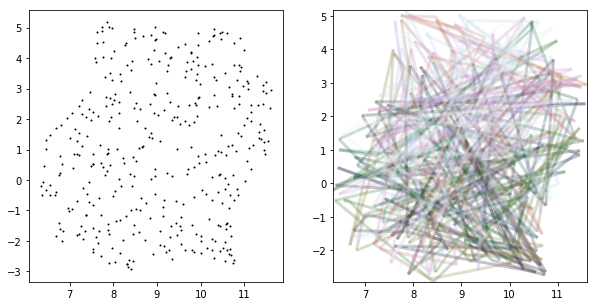

BALB128


[(168,)]


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


(25.0, 10) (320, 800) 25.0 32 800


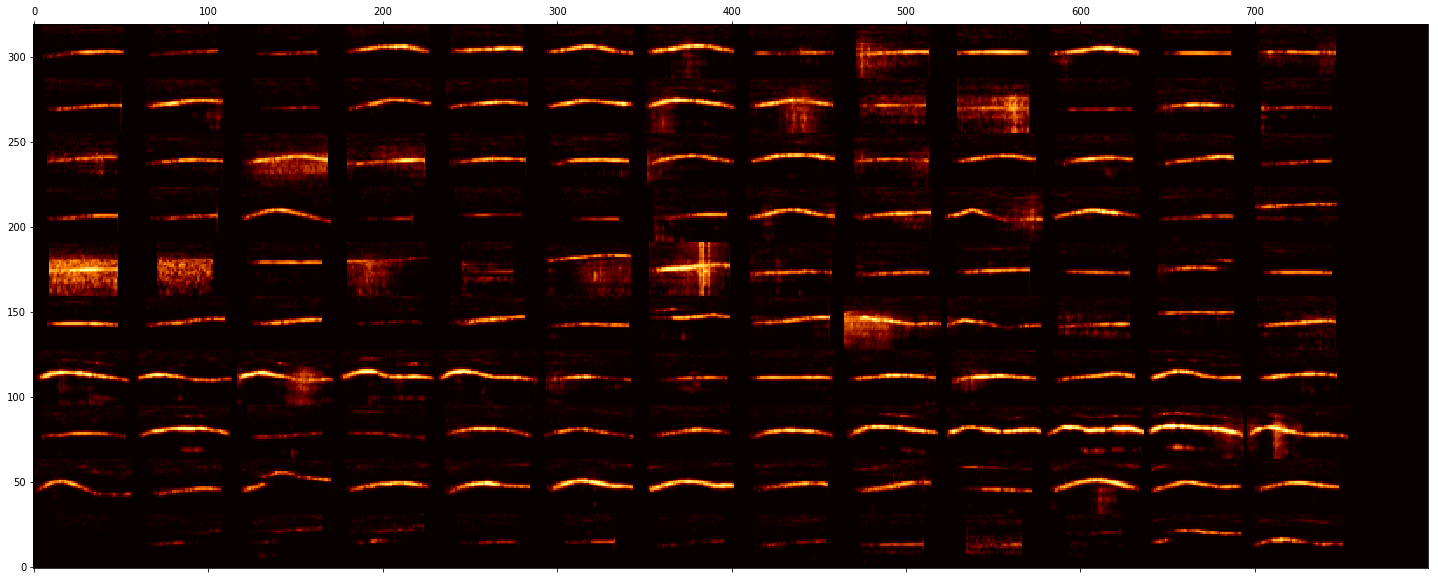

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


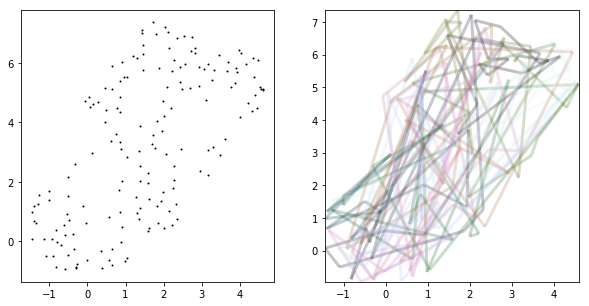

In [201]:
syllable_dfs = {}
for indv in tqdm(dataset._unique_indvs[:3], desc="indvs"):
    print(indv)
    # create dataframe
    syllable_dfs[indv] = create_syllable_df(dataset, [indv], log_scaling_factor=8, n_jobs=1)[:nex]
    
    # plot specs
    spectrograms = syllable_dfs[indv].syllables_spec.values
    draw_spec_set(spectrograms, zoom=1, maxrows=10, colsize=25)
    
    specs_flattened = flatten_spectrograms(
        np.array(list(syllable_dfs[indv].syllables_spec.values))
    )

    fit = umap.UMAP(min_dist=0.25)
    syllable_dfs[indv]["umap"] = list(fit.fit_transform(specs_flattened))

    # plot data
    z = np.vstack(syllable_dfs[indv]["umap"].values)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

    draw_projection_transitions(
        projections=z,
        sequence_ids=syllable_dfs[indv]["syllables_sequence_id"],
        sequence_pos=syllable_dfs[indv]["syllables_sequence_pos"],
        alpha=0.25,
        ax=axs[1],
    )
    
    scatter_projections(projection=z, alpha=1, ax=axs[0])
    plt.show()

In [15]:
syllable_dfs[indv][:3]

,syllables_sequence_id,syllables_sequence_pos,syllables_wav,syllables_rate,syllables_labels,syllables_spec,umap
0,0,0,"[-0.002093457482608874, -0.0018458515197550883...",250000,None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.24...","[1.0528628, 19.036867]"
1,0,1,"[-0.005795450647093846, 0.0003341831010695421,...",250000,None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.46...","[-2.1435769, 20.771132]"
2,0,2,"[-0.0031713334258232466, 0.003175722347471433,...",250000,None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2.3941894, 19.777218]"


In [140]:
import noisereduce as nr

In [167]:
??nr.reduce_noise